In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from base import PromptAttn, p_svm_solver

In [2]:
n = 3
T = 7
d = 3
ITN = 1000
seed = 0
opt_score = 1.
nonopt_score = 0.5
init_p = torch.tensor([
    [1.,0,0],
    [0.5,0,0],
    [0.,0,0],
    [-0.5,0,0],
    [-1.,0,0],
    [-1.5,0,0],
])
ps = np.zeros((init_p.shape[0], ITN, d))
p_norms = np.zeros((init_p.shape[0], 2, ITN))
probs = np.zeros((init_p.shape[0], 2, ITN))

def get_margin(X, p):
    score = 1000
    for i in range(X.shape[0]):
        for t in range(1,X.shape[1]):
            if (X[i,0] - X[i,t]) @ p/p.norm() < score:
                score = (X[i,0] - X[i,t]) @ p/p.norm()
                index = (X[i,0] + X[i,t])/2
    return score, index

def data_generator(generator):
    shift = torch.tensor([
        [1,0,0],
        [-1,1,0],
        [-0.5,-0.5,0],
    ])
    v = torch.tensor([0.,0.,1])
    Y = torch.ones(n)
    X = torch.randn((n, T, d), generator=generator) * 0.2
    X[:,0] += shift[0]
    X[:,1:(T+1)//2] += shift[1]
    X[:,-(T-1)//2:] += shift[2]
    X[:,0,-1] = opt_score
    X[:,1:,-1] = nonopt_score
    return X, Y, v

In [3]:
# normalized GD
for i in range(init_p.shape[0]):
    generator = torch.Generator()
    generator.manual_seed(seed)
    X, Y, v = data_generator(generator)
    model = PromptAttn(d, identity_W=False)
    model.key.weight.data   = torch.tensor([[1.,0,0],[0,1.,0], [0,0,0]])
    model.query.weight.data = torch.tensor([[1.,0,0],[0,1.,0], [0,0,0]])
    model.prompt.data = init_p[i].clone().float().view(-1)
    model.w.data = v.float()
    optimizer = torch.optim.SGD([model.prompt], lr=0.1)
    for it in range(ITN):
        ps[i,it] = model.prompt.detach().numpy()
        optimizer.zero_grad()    
        loss = torch.log(1+torch.exp(-Y*model(X)))
        p_norms[i,0,it] = model.prompt.data.norm()
        probs[i,0,it] = model.attention.detach().numpy()[:,0].mean()
        loss = loss.mean()
        loss.backward()
        model.prompt.grad /= (model.prompt.grad.norm()+0.000000000001)
        optimizer.step()
# GD
for i in range(init_p.shape[0]):
    generator = torch.Generator()
    generator.manual_seed(seed)
    X, Y, v = data_generator(generator)
    model = PromptAttn(d, identity_W=False)
    model.key.weight.data   = torch.tensor([[1.,0,0],[0,1.,0], [0,0,0]])
    model.query.weight.data = torch.tensor([[1.,0,0],[0,1.,0], [0,0,0]])
    model.prompt.data = init_p[i].clone().float().view(-1)
    model.w.data = v.float()
    optimizer = torch.optim.SGD([model.prompt], lr=1)
    for it in range(ITN):
        optimizer.zero_grad()    
        loss = torch.log(1+torch.exp(-Y*model(X)))
        p_norms[i,1,it] = model.prompt.data.norm()
        probs[i,1,it] = model.attention.detach().numpy()[:,0].mean()
        loss = loss.mean()
        loss.backward()
        # model.prompt.grad /= (model.prompt.grad.norm()+0.000000000001)
        optimizer.step()

     pcost       dcost       gap    pres   dres
 0:  2.1463e-01  1.2233e+00  2e+01  1e+00  3e+01
 1:  9.0484e-01 -4.6348e-01  1e+00  3e-02  8e-01
 2:  4.2691e-01  2.3349e-01  2e-01  2e-16  3e-17
 3:  3.1791e-01  2.8049e-01  4e-02  8e-17  2e-16
 4:  3.1649e-01  2.9883e-01  2e-02  1e-16  4e-16
 5:  3.1343e-01  3.1271e-01  7e-04  1e-16  2e-16
 6:  3.1319e-01  3.1318e-01  8e-06  1e-16  3e-16
 7:  3.1319e-01  3.1319e-01  8e-08  1e-16  4e-16
Optimal solution found.


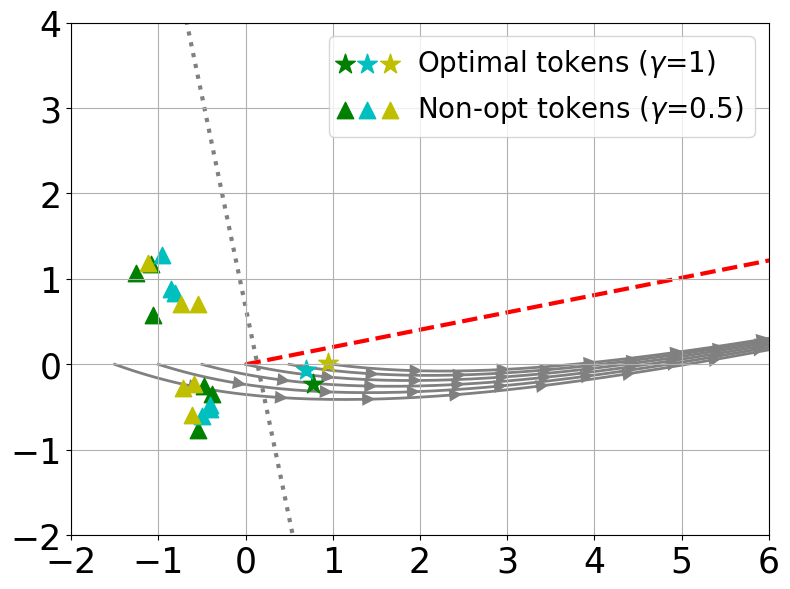

In [4]:
sol, X_ = p_svm_solver(X, torch.diag(torch.ones(d)), torch.zeros(n).long())
margin, index = get_margin(torch.tensor(np.array(X_)), torch.tensor(np.array(sol)).float())
bias = (index[0]/sol[1]*sol[0]+index[1])/sol[0]*sol[1]

plt.figure(figsize=(8,6))
colors = ['g','c','y']
markers = ['*', '^', '^', '^', '^', '^', '^']
ss = [220, 140, 140, 140, 140, 140, 140]
ls_best = ()
ls_support = ()
for i in range(n):
    for t in range(T):
        l = plt.scatter(X[i,t,0],X[i,t,1],color=colors[i], marker=markers[t], s=ss[t])
        if t == 0:
            ls_best += (l,)
        if t == 1:
            ls_support += (l,)

x = np.arange(0,10)
plt.plot(x,sol[1]/sol[0]*x, '--', color='red', linewidth=3, zorder=-1)
plt.plot([-10+bias,10+bias],[sol[0]/sol[1]*10,-sol[0]/sol[1]*10], ':', color='gray', linewidth=3, zorder=-1)

THRED = 200
for i in range(init_p.shape[0]):
    plt.plot(ps[i,:THRED,0], ps[i,:THRED,1], linewidth=2, linestyle='-', color='gray', zorder=-1)
    for j in range(THRED):
        if (j+1) % 10 == 0:
            plt.arrow((ps[i,j,0]), (ps[i,j,1]), (ps[i,j+1,0]-ps[i,j,0]), (ps[i,j+1,1]-ps[i,j,1]), length_includes_head=True,head_width=0.1, head_length=0.1, color='gray', linewidth=2, zorder=-1)


plt.legend([ls_best, ls_support], [r'Optimal tokens ($\gamma$=1)', r'Non-opt tokens ($\gamma$=0.5)'], fontsize=20, loc='upper right', handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)})
plt.xlim([-2,6])
plt.ylim([-2,4])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid()
plt.tight_layout()
plt.show()

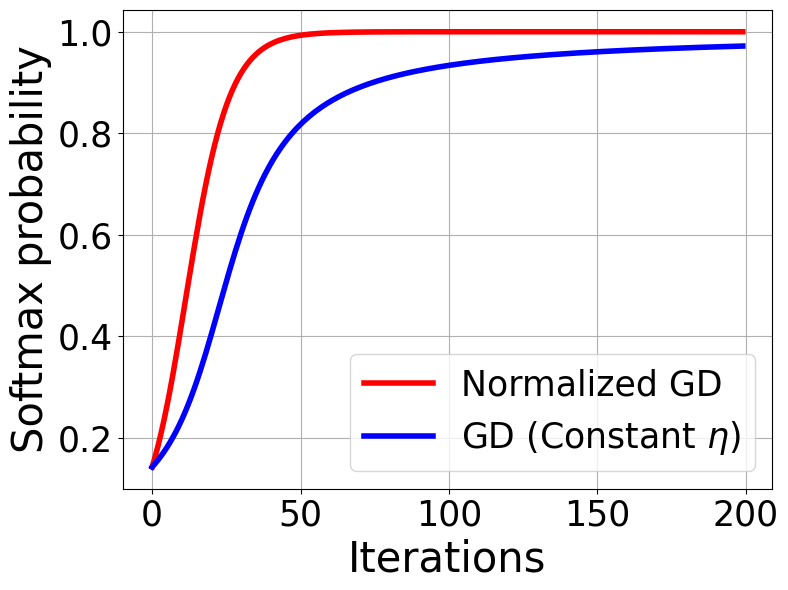

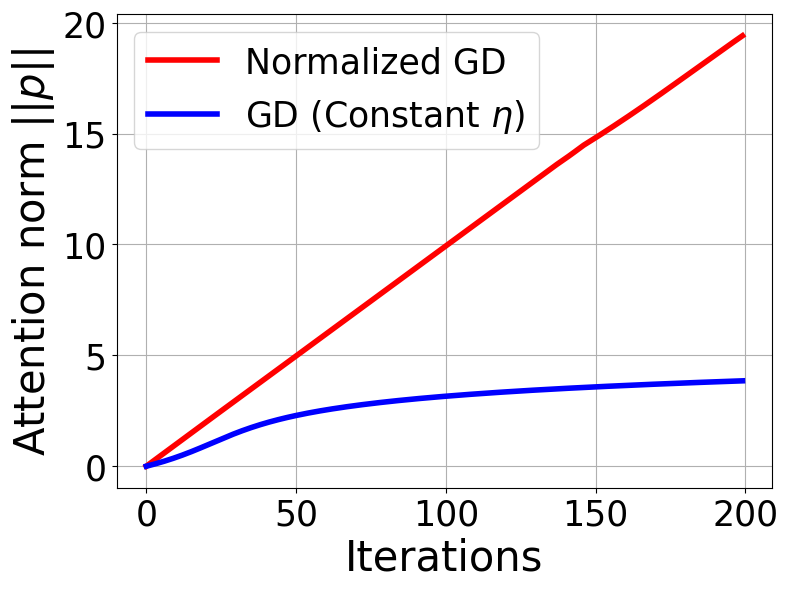

In [5]:
THRED = 200
idx = 2
plt.figure(figsize=(8,6))
plt.plot(probs[idx,0,:THRED], linewidth=4, color='red')
plt.plot(probs[idx,1,:THRED], linewidth=4, color='blue')
plt.xticks([0,50,100,150,200], fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Iterations', fontsize=30)
plt.ylabel('Softmax probability', fontsize=30)
plt.legend(['Normalized GD', r'GD (Constant $\eta$)'], fontsize=25)
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(p_norms[idx,0,:THRED], linewidth=4, color='red')
plt.plot(p_norms[idx,1,:THRED], linewidth=4, color='blue')
plt.xticks([0,50,100,150,200], fontsize=25)
plt.yticks([0,5,10,15,20], fontsize=25)
plt.xlabel('Iterations', fontsize=30)
plt.ylabel(r'Attention norm $||p||$', fontsize=30)
plt.legend(['Normalized GD', r'GD (Constant $\eta$)'], fontsize=25)
plt.grid()
plt.tight_layout()
plt.show()